In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
from wordcloud import WordCloud

 ## Завантаження NLTK ресурсів:

In [ ]:

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

#  Завантаження даних:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_PATH = Path('/content/drive/MyDrive/MERGE_Bimodal_Balanced')
LYRICS_PATH = DATA_PATH / 'lyrics'
PROCESSED_FILE = DATA_PATH / 'processed_data_with_emotions.csv'

df = pd.read_csv(PROCESSED_FILE)

Mounted at /content/drive


# Читання текстів пісень:

In [ ]:
def read_lyrics_file(lyric_id, lyrics_path):
    for quarter_dir in lyrics_path.iterdir():
        lyric_file = quarter_dir / f"{lyric_id}.txt"
        with open(lyric_file, 'r', encoding='utf-8') as f:
            return f.read()
    return None

lyrics_list = []
missing_lyrics = []

for idx, row in df.iterrows():
    lyric_id = row['Lyric_Song']
    lyrics = read_lyrics_file(lyric_id, LYRICS_PATH)

    if lyrics:
        lyrics_list.append(lyrics)
    else:
        lyrics_list.append("")
        missing_lyrics.append(lyric_id)

    if (idx + 1) % 500 == 0:
        print(f"  Прочитано {idx + 1}/{len(df)} файлів...")

df['lyrics_raw'] = lyrics_list
df['lyrics_length'] = df['lyrics_raw'].apply(lambda x: len(x) if x else 0)
print(f"\nCтатистика довжини текстів (символів):")
print(df['lyrics_length'].describe())


  Прочитано 500/2000 файлів...
  Прочитано 1000/2000 файлів...
  Прочитано 1500/2000 файлів...
  Прочитано 2000/2000 файлів...

Cтатистика довжини текстів (символів):
count    2000.000000
mean     1259.447500
std       857.735339
min        74.000000
25%       701.000000
50%      1002.000000
75%      1474.000000
max      5388.000000
Name: lyrics_length, dtype: float64


Препроцесинг тексту:

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

custom_stop_words = {
    'verse', 'chorus', 'bridge', 'intro', 'outro', 'repeat',
    'x2', 'x3', 'x4', 'instrumental', 'oh', 'ooh', 'yeah', 'na'
}
stop_words.update(custom_stop_words)

def clean_text(text):
    if not text or len(text) == 0:
        return ""

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text, remove_stopwords=True, use_lemmatization=True):
    if not text:
        return "", []
    text = clean_text(text)
    tokens = word_tokenize(text)

    tokens = [w for w in tokens if len(w) > 2]

    if remove_stopwords:
        tokens = [w for w in tokens if w not in stop_words]

    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    else:
        tokens = [stemmer.stem(w) for w in tokens]

    processed_text = ' '.join(tokens)
    return processed_text, tokens


# Обробка текстів:

In [ ]:

processed_texts = []
all_tokens = []

for idx, text in enumerate(df['lyrics_raw']):
    processed, tokens = preprocess_text(text)
    processed_texts.append(processed)
    all_tokens.append(tokens)

    if (idx + 1) % 500 == 0:
        print(f"  Оброблено {idx + 1}/{len(df)} текстів...")

df['lyrics_processed'] = processed_texts
df['lyrics_tokens'] = all_tokens
df['num_tokens'] = df['lyrics_tokens'].apply(len)

print(f"\nСтатистика кількості токенів:")
print(df['num_tokens'].describe())

  Оброблено 500/2000 текстів...
  Оброблено 1000/2000 текстів...
  Оброблено 1500/2000 текстів...
  Оброблено 2000/2000 текстів...

Статистика кількості токенів:
count    2000.000000
mean      126.919000
std        89.101914
min         7.000000
25%        70.000000
50%        99.000000
75%       148.000000
max       571.000000
Name: num_tokens, dtype: float64

Приклад обробки тексту:

Пісня: Louis Armstrong - What a Wonderful World
Квадрант: Q4_Calm_Relaxed
Valence: 0.894, Arousal: 0.294

Оригінальний текст (перші 200 символів):
I see trees of green, red roses too
I see them bloom for me and you
And I think to myself what a wonderful world.

I see skies of blue and clouds of white
The bright blessed day, the dark sacred night...

Оброблений текст (перші 200 символів):
see tree green red rose see bloom think wonderful world see sky blue cloud white bright blessed day dark sacred night think wonderful world color rainbow pretty sky also face people going see friend s...

Токени (перші 2

# Аналіз частотності слів:


Загальна статистика:
  • Унікальних слів: 15,386
  • Всього слів: 253,838

Топ-20 найчастіших слів:
  love            :  3601
  dont            :  2952
  like            :  2835
  got             :  2724
  know            :  2714
  get             :  2255
  baby            :  2042
  come            :  1820
  time            :  1801
  let             :  1721
  one             :  1621
  see             :  1545
  youre           :  1468
  make            :  1433
  never           :  1378
  want            :  1353
  cant            :  1299
  say             :  1288
  nigga           :  1238
  gon             :  1214

Аналіз слів по емоційних квадрантах:

Q4_Calm_Relaxed:
  Топ-10 слів:
    love            : 1154
    know            :  518
    come            :  427
    dont            :  393
    one             :  387
    let             :  386
    like            :  367
    time            :  351
    baby            :  342
    see             :  339

Q3_Sad_Depressed:
  Топ-10 слів:
    

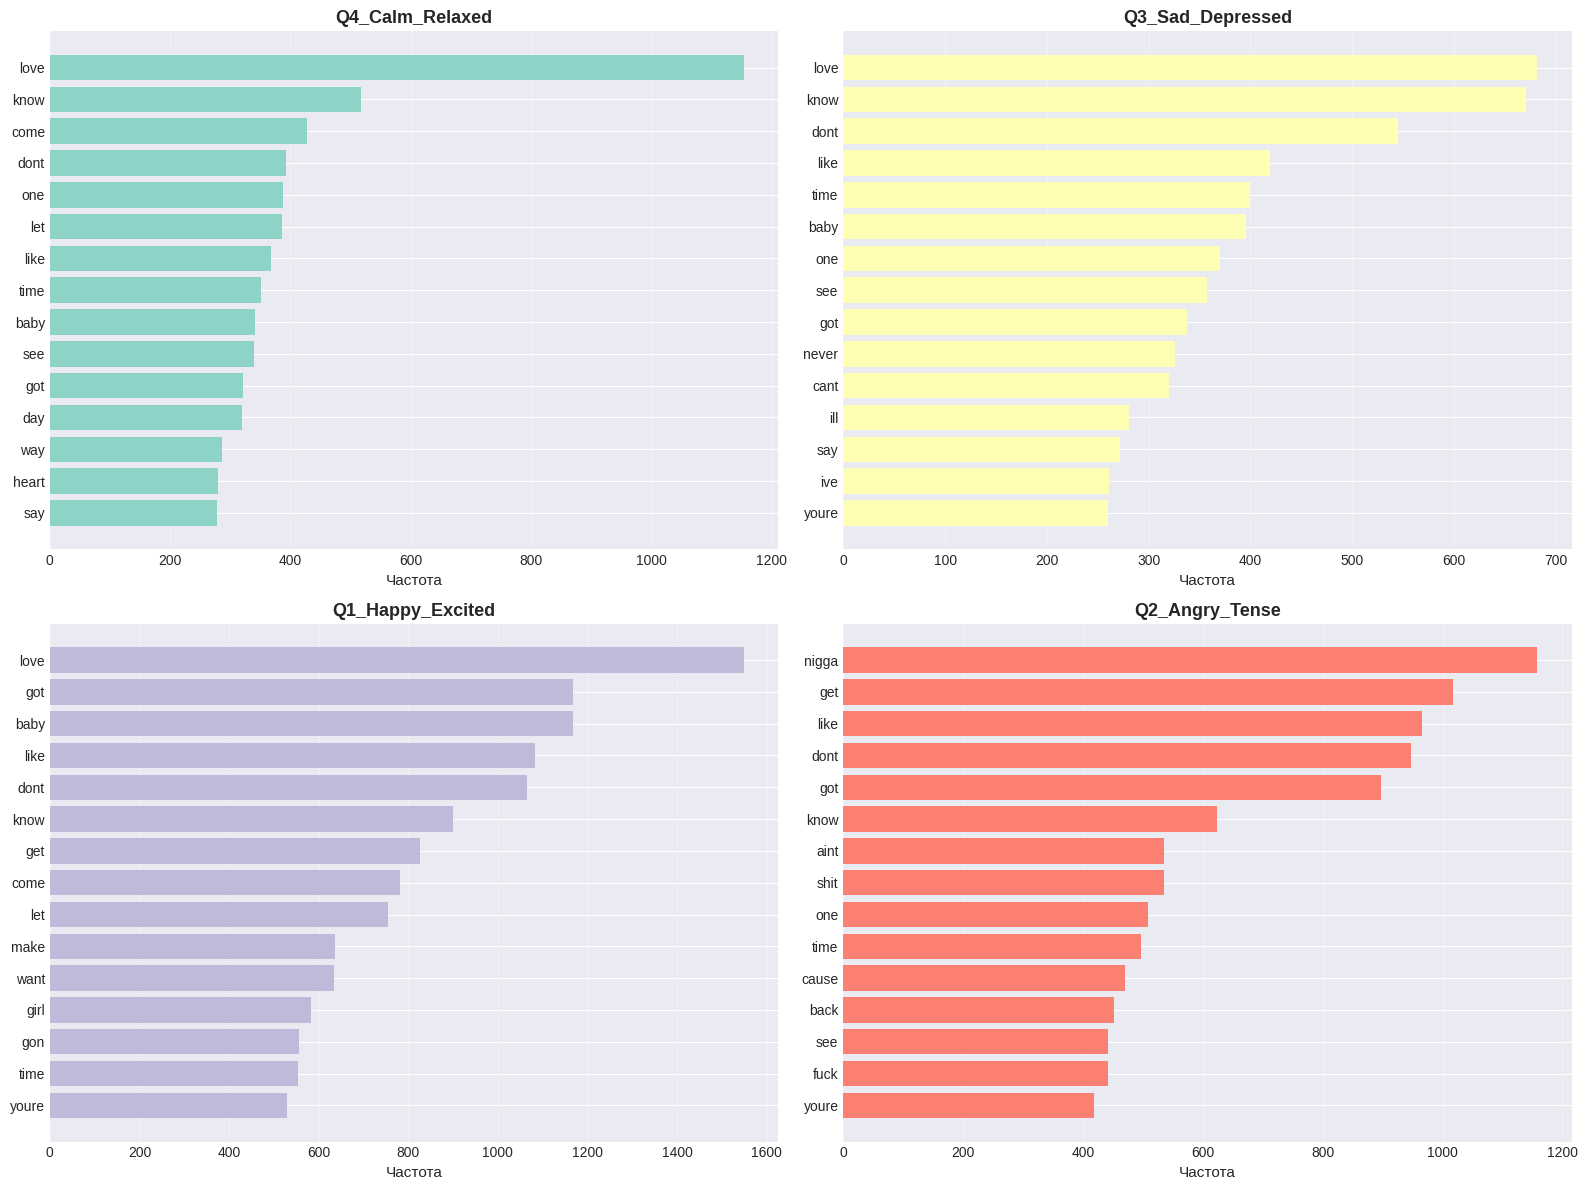

In [ ]:

all_words = [word for tokens in df['lyrics_tokens'] for word in tokens]
word_freq = Counter(all_words)

print(f"\nЗагальна статистика:")
print(f"Унікальних слів: {len(word_freq):,}")
print(f"Всього слів: {sum(word_freq.values()):,}")

print(f"\nТоп-20 найчастіших слів:")
for word, count in word_freq.most_common(20):
    print(f"  {word:15s} : {count:5d}")

print("\nАналіз слів по емоційних квадрантах:")

quadrant_words = {}
for quadrant in df['emotion_quadrant'].unique():
    quadrant_df = df[df['emotion_quadrant'] == quadrant]
    words = [word for tokens in quadrant_df['lyrics_tokens'] for word in tokens]
    quadrant_words[quadrant] = Counter(words)

    print(f"\n{quadrant}:")
    print(f"  Топ-10 слів:")
    for word, count in quadrant_words[quadrant].most_common(10):
        print(f"    {word:15s} : {count:4d}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (quadrant, word_counter) in enumerate(quadrant_words.items()):
    top_words = dict(word_counter.most_common(15))

    axes[idx].barh(list(top_words.keys()), list(top_words.values()),
                   color=plt.cm.Set3(idx))
    axes[idx].set_xlabel('Частота', fontsize=11)
    axes[idx].set_title(f'{quadrant}', fontsize=13, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


# WORD CLOUDS по емоційних квадрантах:

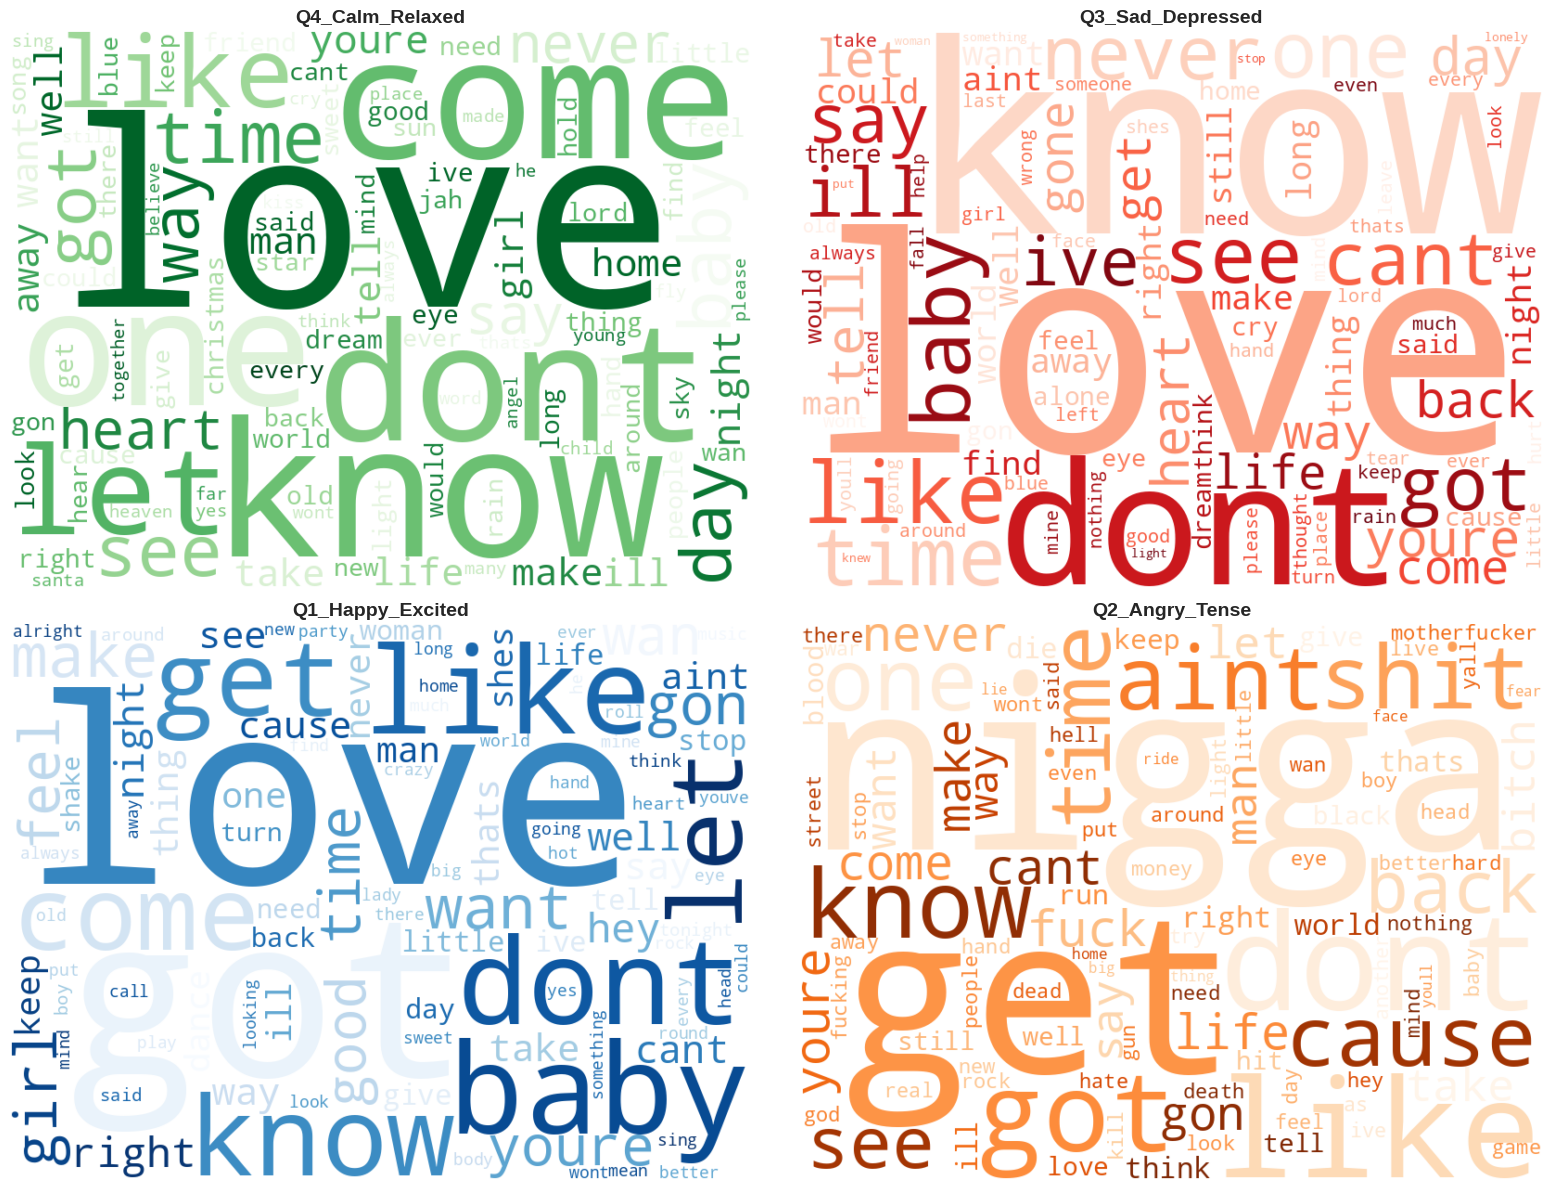

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['Greens', 'Reds', 'Blues', 'Oranges']

for idx, (quadrant, word_counter) in enumerate(quadrant_words.items()):
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        colormap=colors[idx],
        max_words=100,
        relative_scaling=0.5
    ).generate_from_frequencies(word_counter)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{quadrant}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# TF-IDF ВЕКТОРИЗАЦІЯ

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\w{3,}'
)


texts_for_tfidf = df['lyrics_processed'].fillna('')
tfidf_matrix = tfidf_vectorizer.fit_transform(texts_for_tfidf)

print(f"   Розмір TF-IDF матриці : {tfidf_matrix.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nВсього features: {len(feature_names)}")
print("\nНАЙВАЖЛИВІШІ TF-IDF FEATURES ПО КВАДРАНТАХ:")

for quadrant in df['emotion_quadrant'].unique():
    quadrant_indices = df[df['emotion_quadrant'] == quadrant].index
    quadrant_tfidf = tfidf_matrix[quadrant_indices].mean(axis=0)
    quadrant_tfidf = np.asarray(quadrant_tfidf).flatten()

    top_indices = quadrant_tfidf.argsort()[-15:][::-1]
    top_features = [(feature_names[i], quadrant_tfidf[i]) for i in top_indices]

    print(f"\n{quadrant}:")
    for feature, score in top_features:
        print(f"  {feature:20s} : {score:.4f}")


   Розмір TF-IDF матриці : (2000, 5000)
   (документи × features)

Всього features: 5000
   Приклади: ['aah', 'able', 'absence', 'abused', 'accept', 'ace', 'acid', 'across', 'across sky', 'act', 'act like', 'actin', 'acting', 'action', 'add', 'admit', 'adore', 'advantage', 'advice', 'affair']

НАЙВАЖЛИВІШІ TF-IDF FEATURES ПО КВАДРАНТАХ:

Q4_Calm_Relaxed:
  love                 : 0.0535
  know                 : 0.0232
  come                 : 0.0228
  heart                : 0.0219
  day                  : 0.0214
  let                  : 0.0204
  night                : 0.0197
  christmas            : 0.0193
  time                 : 0.0190
  one                  : 0.0189
  baby                 : 0.0182
  never                : 0.0182
  way                  : 0.0180
  see                  : 0.0179
  like                 : 0.0176

Q3_Sad_Depressed:
  love                 : 0.0418
  know                 : 0.0366
  dont                 : 0.0288
  baby                 : 0.0247
  time          

# Результати:

In [ ]:

output_file = DATA_PATH / 'processed_data_with_text_features.csv'
df.to_csv(output_file, index=False)
import pickle

tfidf_output = DATA_PATH / 'tfidf_matrix.pkl'
with open(tfidf_output, 'wb') as f:
    pickle.dump({
        'matrix': tfidf_matrix,
        'vectorizer': tfidf_vectorizer,
        'feature_names': feature_names
    }, f)

word_stats_output = DATA_PATH / 'word_statistics.pkl'
with open(word_stats_output, 'wb') as f:
    pickle.dump({
        'overall_freq': word_freq,
        'quadrant_freq': quadrant_words
    }, f)
print(f"Статистика слів збережена: {word_stats_output}")


print("\nПідсумок:")
print(f"Оброблено текстів: {len(df)}")
print(f"Унікальних слів: {len(word_freq):,}")
print(f"TF-IDF features: {tfidf_matrix.shape[1]}")
print(f"Середня довжина тексту: {df['num_tokens'].mean():.1f} токенів")


Статистика слів збережена: /content/drive/MyDrive/MERGE_Bimodal_Balanced/word_statistics.pkl

Підсумок:
  • Оброблено текстів: 2000
  • Унікальних слів: 15,386
  • TF-IDF features: 5000
  • Середня довжина тексту: 126.9 токенів
